Variables of filenames

In [1]:
#PLAINTREE FILES NAMES
directory='/Users/julnow/gsi/cbm/ML/JupyterNotebooks/'
signalFileName = directory + 'PlainTree_100kSign.root'
backgroundFileName = directory + 'PlainTree_5kBckgr.root'

# Importing the Libraries

**Numpy** is a powerful library that makes working with python more efficient, so we will import it and use it as np in the code. **Pandas** is another useful library that is built on numpy and has two great objects *series* and *dataframework*. Pandas works great for *data ingestion* and also has *data visualization* features. **Matplotlib** and **Seaborn** come handy in plotting and visualizing the data. From **Hipe4ml** we import **TreeHandler** and with the help of this function we will import our *Analysis Tree* to our notebook. We will also need some functions of **Scipy** for fittintg. **Seaborn** will be used to prepare the heatmap of the correlations of all variables. **gc** - garbage collector will get rid of unnecessary data; **os** will create the folder for graphs.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sn
#from hipe4ml.tree_handler import TreeHandler
#from hipe4ml import plot_utils
from matplotlib.patches import ConnectionPatch
from scipy.stats import binned_statistic as b_s
from scipy.stats import linregress
from scipy.optimize import curve_fit
from scipy.stats import chisquare
from sklearn import datasets, linear_model
import gc
import os

To import the root files with simulated data as PlainTrees into Panda's dataframes format we use the function from **CBM_ML_LAMBDA_LIBRARY** prepared by Shahid.

In [3]:
#Shahid's library for importing roottrees
#%%capture
!git clone https://github.com/shahidzk1/CBM_ML_Lambda_Library.git
%cd CBM_ML_Lambda_Library
!git pull origin main
!pip install -r requirements.txt
!python setup.py install
from CBM_ML import tree_importer, plot_tools, KFPF_lambda_cuts

fatal: destination path 'CBM_ML_Lambda_Library' already exists and is not an empty directory.
/Users/julnow/gsi/cbm/ML/JupyterNotebooks/CBM_ML_Lambda_Library
hint: Pulling without specifying how to reconcile divergent branches is
hint: discouraged. You can squelch this message by running one of the following
hint: commands sometime before your next pull:
hint: 
hint:   git config pull.rebase false  # merge (the default strategy)
hint:   git config pull.rebase true   # rebase
hint:   git config pull.ff only       # fast-forward only
hint: 
hint: You can replace "git config" with "git config --global" to set a default
hint: preference for all repositories. You can also pass --rebase, --no-rebase,
hint: or --ff-only on the command line to override the configured default per
hint: invocation.
From https://github.com/shahidzk1/CBM_ML_Lambda_Library
 * branch            main       -> FETCH_HEAD
Already up to date.
running install
running bdist_egg
running egg_info
writing CBM_ML.egg-info/PKG

With the help of a selection cut, we select only signal candidates and background candidates from their respective data sets. Another selection cut chooses K-short candidates only in the $\pm 5\sigma$ region around the mean of the lambda mass peak. Similarly, we select the background candidates outside this $\pm 5\sigma$ region.

In [4]:
#CUTS FOR MASS SELECTION
#5 sigma region for signal
lower5SigmaCutSign = 0.43485
upper5SigmaCutSign = 0.56135
#mean invariant mass
invMass = 0.4981
# "5sigma" (not acutal 5 sigma) region for background
lower5SigmaCutBckgr = 0.1
upper5SigmaCutBckgr = 2

In [5]:
# We import three root files into our jupyter notebook
#sign - before cleaning but after 5sigma seletion, signal - cleaned
#so that we dont have to reimport everything with each change
sign = tree_importer.tree_importer(signalFileName,'PlainTree',7)

# We only select lambda candidates in the 5 sigma region around the kaon mass peak
#we preserve the cleaned dataframe with a changed name
sign = sign[(sign['Candidates_generation']==1) & (sign['Candidates_mass']>lower5SigmaCutSign) & (sign['Candidates_mass']<upper5SigmaCutSign)]

# Similarly for the background, we select background candidates which are not in the 5 sigma region of the kaon peak
bckgr = tree_importer.tree_importer(backgroundFileName,'PlainTree',7)
#we preserve the cleaned dataframe with a changed name
bckgr = bckgr[(bckgr['Candidates_generation'] < 1)
                 & ((bckgr['Candidates_mass'] > lower5SigmaCutBckgr)
# we dont apply this condition to not create a gap in the distribution   
                    #& (bckgr['Candidates_mass'] < lower5SigmaCutSign) | (bckgr['Candidates_mass']>upper5SigmaCutSign) 
                    & (bckgr['Candidates_mass'] < upper5SigmaCutBckgr))]


As the PlainTrees contain some unnecessary prefixes in the column names, we'll remove them. We also drop columns not used in the analysis. To prepare the graphs, we prepare the names of the columns and the axis labels in the LaTex format.

In [6]:
#we remove name prefixes 'Candidates'
bckgr.columns = bckgr.columns.str.replace('Candidates_', '')
bckgr.columns = bckgr.columns.str.replace('_', '')
sign.columns = sign.columns.str.replace('Candidates_', '')
sign.columns = sign.columns.str.replace('_', '')
#we also get rid of coordinates errors
sign = sign.drop(columns=['xerror', 'yerror', 'zerror', 'daughter1id', 'daughter2id', 'pid', 'pTerr', 'etaerr', 'masserr', 'phierr']).rename(columns={'generation' : 'issignal'})
bckgr = bckgr.drop(columns=['xerror', 'yerror', 'zerror', 'daughter1id', 'daughter2id', 'pid', 'pTerr', 'etaerr', 'masserr', 'phierr']).rename(columns={'generation' : 'issignal'})
#let's check the name prefixes 
#lets also create a dataframe with both bckgr and sign
#Also call the garbage collector of python to collect unused items to free memory
print(sign.iloc[0:10,:])
gc.collect()

    chi2geo  chi2primfirst  chi2primsecond  chi2topo  cosinefirst  \
0  4.055893   1.330057e+04    5.165652e+03  1.778087     0.959008   
1  3.636602   1.436521e+04    1.923592e+07  4.453396     0.907031   
2  6.397780   1.038508e+05    1.920486e+04  2.716656     0.946062   
3  0.397102   2.995777e+06    1.971392e+07  1.121992     0.987038   
4  5.643604   8.308374e+06    6.646880e+06  2.601776     0.960421   
5  1.190653   1.881944e+05    1.126294e+06  1.427140     0.995952   
6  1.676148   1.591342e+05    2.167089e+06  1.230222     0.984069   
7  0.005970   1.591342e+05    3.279188e+03  0.626098     0.984079   
8  0.044970   9.004700e+04    1.591051e+06  0.799062     0.961274   
9  9.126056   1.470450e+01    5.561668e+03  7.014366     0.988972   

   cosinesecond  cosinetopo  distance       eta          l  ...        pT  \
0      0.966144    0.999981  0.025621  2.448879   1.008903  ...  0.258358   
1      0.978252    0.999785  0.527148  1.734524   7.282530  ...  0.433889   
2      0.

2506

In [7]:
#lets set data labels in latex format
print(sign.columns)
names=['$\chi^2_{geo}$', '$\chi^2_{prim first}$','$\chi^2_{prim second}$','$\chi^2_{topo}$', 
       '$cosine_{first}$', '$cosine_{second}$',  '$cosine_{topo}$', 'DCA', '$\eta$', 
       '$l$', '$\dfrac{l}{\Delta l}$', 'invariant mass', '$p$', '$pT$', '$\phi$', 
       '$p_x$', '$p_y$', '$p_z$', 'rapidity', '$x$', '$y$', '$z$']
#xlabels with unit
xNames=['$\chi^2_{geo}$', '$\chi^2_{prim first}$','$\chi^2_{prim second}$','$\chi^2_{topo}$', 
        '$cosine_{first}$', '$cosine_{second}$',  '$cosine_{topo}$', 'DCA (cm)', 
        '$\eta$', '$l$ (cm)', '$\dfrac{l}{\Delta l}$', 'invariant mass (GeV/$c^2$)', '$p (GeV/c)$', 
        '$pT$ $(GeV/c)$', '$\phi$ $(rad)$', '$p_x$ $(GeV/c)$', '$p_y$ $(GeV/c)$', '$p_z$ $(GeV/c)$', 
        'rapidity', '$x$ $(cm)$', '$y$ $(cm)$', '$z$ $(cm)$']

Index(['chi2geo', 'chi2primfirst', 'chi2primsecond', 'chi2topo', 'cosinefirst',
       'cosinesecond', 'cosinetopo', 'distance', 'eta', 'l', 'loverdl', 'mass',
       'p', 'pT', 'phi', 'px', 'py', 'pz', 'rapidity', 'x', 'y', 'z',
       'issignal'],
      dtype='object')


# Correlation
We find the correlation of all variables with signal and background candidates. We use the pearson correlation coefficient (linear correlation) for our analysis. It is defined as 
$$
\rho = \frac{COV(X,Y)}{\sigma_X \times \sigma_Y}
$$
Here, COV(X,Y) is the covariance of the variable X and Y, and $\sigma_X$ and $\sigma_Y$ are the standard deviations of the variables. Pearson co-efficient is useful for linear correlation but it fails to take into account outliers and non-linear correlation. $\rho \> 0$ means postive while the opposite means negative correlation between two variables. 

This correlation function comes in built in the pandas library so we are using it. This function can also find other non-linear correlation coefficients like kendall and spearman. 

In this notebook, we'll draw it for both signal and background

In [8]:
variables_to_draw = ['chi2geo', 'chi2primfirst', 'chi2primsecond', 'chi2topo', 'cosinefirst',
       'cosinesecond', 'cosinetopo', 'distance', 'eta', 'l', 'loverdl',
       'mass', 'p', 'pT', 'phi', 'px', 'py', 'pz', 'rapidity', 'issignal']

In [9]:
if not os.path.exists(directory+'img/correlations'):
    os.makedirs(directory+'img/correlations')
def correlation_graph(df, variables, title):
    # The variables pid, isfrompv and issignal are not that much varying so we remove them
    new_df = df[variables]
    # Using the pandas correlation function corr we find the correlation
    df_correlation_all = new_df.corr(method='pearson')
    
    #The cosmetics of the graph
    fig, ax = plt.subplots(figsize=(20,15))  #figure size
    cmap = sn.diverging_palette(240, 10, as_cmap=True, n=200) #color map
    cax = sn.heatmap(df_correlation_all, annot=True,cbar_kws={"shrink": .5},  cmap=cmap,  vmin=-1, vmax=1, 
                 center=0)
    ax.set_xticks(np.arange(0, len(df_correlation_all.columns), step=1))
    ax.set_xticklabels(df_correlation_all.columns, fontsize=15, rotation =70)
    ax.set_yticklabels(df_correlation_all.columns, fontsize=15)
    ax.set_title(title, fontsize = 20)
    fig.tight_layout()
    fig.savefig(directory+'img/correlations/'+title.replace(' ', '_')+'.pdf')
    fig.savefig(directory+'img/correlations/'+title.replace(' ', '_')+'.png')

10

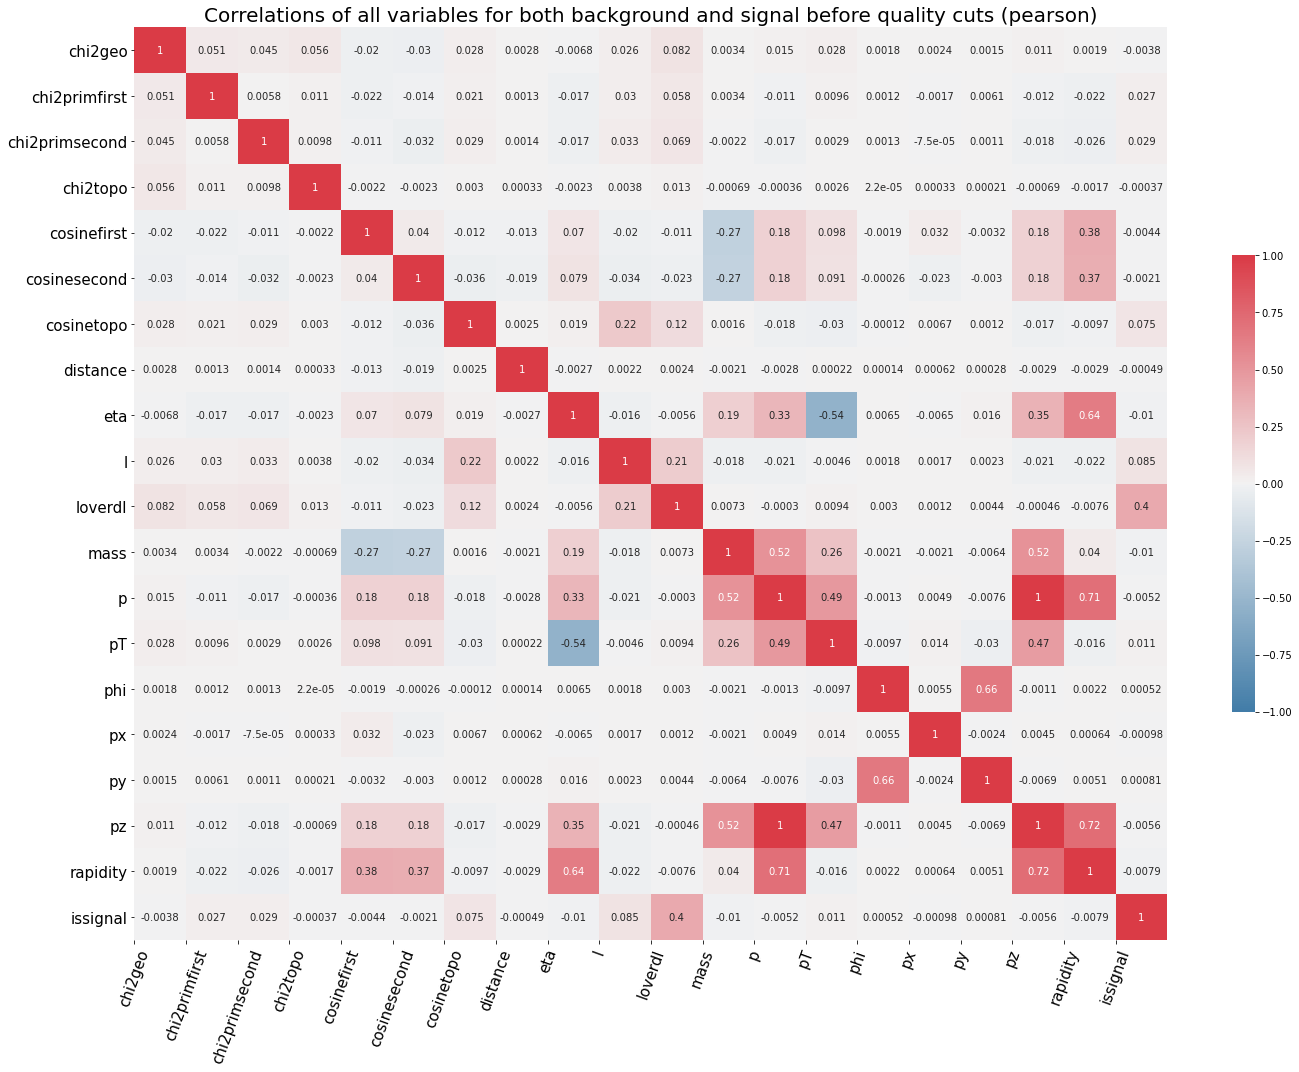

In [10]:
#correlation graph for both signal and background
#both signal and background
sign_and_bckgr_before = pd.concat([sign, bckgr])
correlation_graph(sign_and_bckgr_before, variables_to_draw, 'Correlations of all variables for both background and signal before quality cuts (pearson)')
del sign_and_bckgr_before
gc.collect()

# Data Cleaning
Similarly as for the pt 1 of the notebook, we'll do the same data cleaning

The values of these cuts are described: https://drive.google.com/file/d/1tb0FBRq4KgVu-VQZgpjA8ONbIGVCNOnE/view?usp=sharing https://github.com/julnow/JupyterNotebooks/blob/kaon/CBM%20K-short%20data%20cleaning.pdf

In [11]:
#CUTS USED FOR DATA CLEANING
#mass cuts for both bckgr and sign
lowerMassCut = 0.279
upperMassCut = 1.5
#distance cuts
#DCA
lowerDcaCut = 0
upperDcaCut = 100
#l distance
lowerLCut = 0
upperLCut = 80
#loverdl
lowerLdlCut = 0
upperLdlCut = 15000
#coordinate cuts
absXCut = 50
absYCut = 50
lowerZCut = 0
upperZCut = 80
#momentums cuts
pzLowerCut = 0
pUpperCut = 20
ptUpperCut = 3
#chi2
#geo
lowerChi2GeoCut = 0
upperChi2GeoCut = 1000
#topo
lowerChi2TopoCut = 0
upperChi2TopoCut = 100000
#prim first
lowerChi2PrimFirstCut = 0
upperChi2PrimFirstCut = 3e7
#prim second
lowerChi2PrimSecondCut = 0
upperChi2PrimSecondCut = 3e7
#pseudorapidity cuts
lowerEtaCut = 1.
upperEtaCut = 6.5

In [12]:
def clean_df(df):
    # let's treat all the infinite, inf, values by nan and then we drop all the null entries
    with pd.option_context('mode.use_inf_as_na', True):
        df = df.dropna()
    #Experimental constraints
    is_good_mom = (df['pz'] > pzLowerCut) & (df['p']<pUpperCut) & (df['pT']<ptUpperCut)
    is_good_coord = (abs(df['x']) < absXCut) & (abs(df['y']) < absYCut) & (df['z']>lowerZCut) & (df['z']<upperZCut)
    is_good_params = (df['distance'] > lowerDcaCut) & (df['distance'] < upperDcaCut) & (df['chi2geo']>lowerChi2GeoCut) & (df['chi2geo'] < upperChi2GeoCut) & (df['chi2topo'] > lowerChi2TopoCut) & (df['chi2topo'] < upperChi2TopoCut) & (df['eta']>lowerEtaCut) & (df['eta']<upperEtaCut)& (df['l']>lowerLCut) & (df['l']<upperLCut) & (df['loverdl']>lowerLdlCut) & (df['loverdl']<upperLdlCut)
    is_good_daughters = (df['chi2primfirst']>lowerChi2PrimFirstCut) & (df['chi2primfirst'] < upperChi2PrimSecondCut) & (df['chi2primsecond']>lowerChi2PrimSecondCut) & (df['chi2primsecond']<upperChi2PrimFirstCut)
    is_good_mass = (df['mass']>lowerMassCut) & (df['mass']<upperMassCut)

    is_good_df = (is_good_mom) & (is_good_coord) & (is_good_params) & (is_good_daughters) & (is_good_mass)

    return df[is_good_df]

In [13]:
background = clean_df(bckgr)
signal = clean_df(sign)
del sign, bckgr
gc.collect()

31481

10

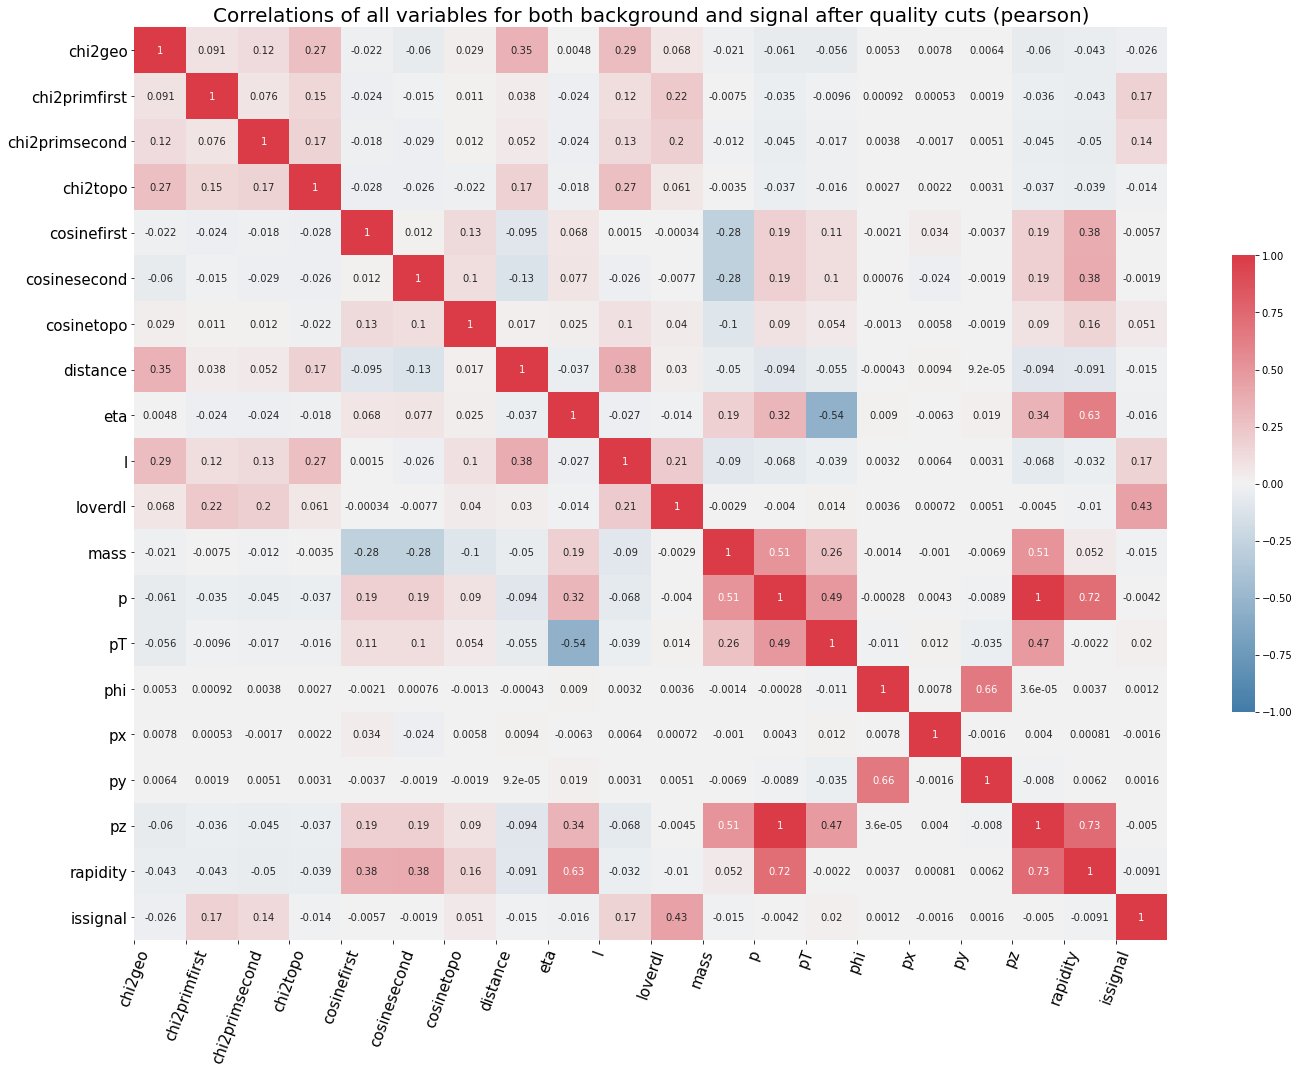

In [14]:
#lets create a map of the correlations once again
sign_and_bckgr_after =  pd.concat([signal, background])
correlation_graph(sign_and_bckgr_after, variables_to_draw, 'Correlations of all variables for both background and signal after quality cuts (pearson)')
del sign_and_bckgr_after
gc.collect()

## Correlations by formula
The following function calculates the correlation along with the standard error of the mean (SEM) of the input variable with all the other variables. The standard error of the mean is defined as $ SEM = \frac{\sigma}{\sqrt{n}}$. Here $\sigma$ is the standard deviation of a variable. It will put error bars on each bin.

The function accepts 3 variables, a data frame object in the first input, a list of strings to be correlated with the third input (a string).

In [15]:
def calculate_correlation(df, vars_to_corr, target_var) :
    
    from scipy.stats import sem

    mean = df[target_var].mean()
    sigma = df[target_var].std()

    correlation = []
    error = []
    
    for j in vars_to_corr : 
        mean_j = df[j].mean()
        sigma_j = df[j].std()
        
        cov = (df[j] - mean_j) * (df[target_var] - mean) / (sigma*sigma_j)        
        correlation.append(cov.mean())
        error.append(sem(cov))
    
    return correlation, error

In [16]:
# Provide the data frame object first, then also inside the brackets of list and then write the variable inside inverted commas ''.
# For signal
corr_signal, corr_signal_errors = calculate_correlation(signal, list(signal), 'mass')
# For background
corr_bg, corr_bg_errors = calculate_correlation(background, list(background), 'mass')

Again, let's take a look at the correlations of all variables with the mass

/var/folders/_8/1pnnpyz111s3q4bf02xypbgc0000gn/T/ipykernel_84757/4014788736.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(signal.columns, fontsize=15, rotation =90)


Text(0.5, 1.0, 'Correlation of all variables with mass along with SEM')

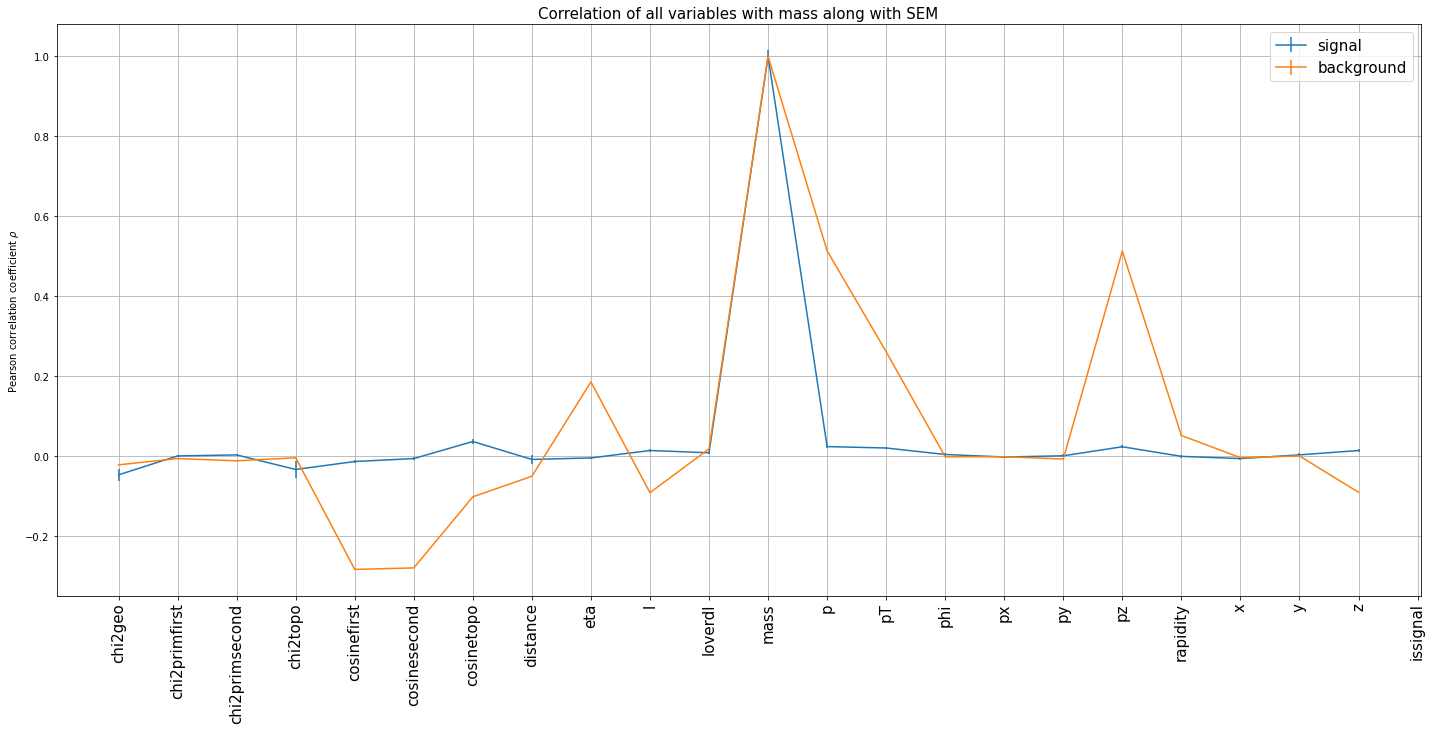

In [17]:
# Plotting the correlations of various variables with mass along with the errors
fig, ax = plt.subplots(figsize=(20,10))
plt.errorbar(list(signal), corr_signal, yerr=corr_signal_errors, fmt='')
plt.errorbar(list(background), corr_bg, yerr=corr_bg_errors, fmt='')
ax.grid(zorder=0)
ax.set_ylabel('Pearson correlation coefficient $\\rho$')
ax.set_xticklabels(signal.columns, fontsize=15, rotation =90)
plt.legend(('signal','background'), fontsize = 15)
plt.tight_layout()
title = 'Correlation of all variables with mass along with SEM'
plt.title(title, fontsize = 15)
#fig.savefig(directory+'img/correlations/'+title.replace(' ', '_')+'.png', bbox_inches='tight')
#fig.savefig(directory+'img/correlations/'+title.replace(' ', '_')+'.pdf', bbox_inches='tight')

In [60]:
#for variable bin size, use the following bins
non_uniform_binning = np.concatenate((np.linspace(lowerMassCut,lower5SigmaCutSign-.006,10), np.linspace(lower5SigmaCutSign,upper5SigmaCutSign-.006,25))) 
non_uniform_binning = np.concatenate((non_uniform_binning, np.linspace(upper5SigmaCutSign,upperMassCut,15)))
non_uniform_binning = non_uniform_binning.tolist()
non_uniform_binning

[0.279,
 0.29565,
 0.3123,
 0.32895,
 0.3456,
 0.36225,
 0.3789,
 0.39555,
 0.4122,
 0.42885,
 0.43485,
 0.4398708333333333,
 0.4448916666666667,
 0.4499125,
 0.45493333333333336,
 0.45995416666666666,
 0.464975,
 0.46999583333333333,
 0.4750166666666667,
 0.4800375,
 0.48505833333333337,
 0.4900791666666667,
 0.4951,
 0.5001208333333333,
 0.5051416666666667,
 0.5101625,
 0.5151833333333333,
 0.5202041666666667,
 0.525225,
 0.5302458333333333,
 0.5352666666666667,
 0.5402875,
 0.5453083333333333,
 0.5503291666666666,
 0.55535,
 0.56135,
 0.6283964285714286,
 0.6954428571428571,
 0.7624892857142858,
 0.8295357142857143,
 0.8965821428571429,
 0.9636285714285715,
 1.030675,
 1.0977214285714285,
 1.1647678571428572,
 1.2318142857142858,
 1.2988607142857145,
 1.365907142857143,
 1.4329535714285715,
 1.5]

Let's take a closer look at the correlations between the mass and: pseudorapidity, cosinecut, pT, pz and p

In [61]:
#let's define different functions that can be fitted
def lin(x, p1, p2):
    return p1*x + p2
def gaus(x,k, b,a,x0,sigma):
    return k*x+b+a*np.exp(-(x-x0)**2/(2*sigma**2))
def logar(x, p1, p2):
    return p1*np.log(x) + p2
def quadr(x, p1, p2):
    return -p1*x*x + p2

In [62]:
if not os.path.exists(directory+'img/correlations/mass/'):
    os.makedirs(directory+'img/correlations/mass/') 
    
def profile_plot_func(df,variable_xaxis,variable_yaxis, sign, pdf_key, func, binning):
    
    #for signal
    if sign == 1:
        keyword = 'signal'
        if variable_xaxis=='mass':
            df = df[(df['mass'] < upper5SigmaCutSign) & (df['mass'] > lower5SigmaCutSign)]
            unit = r'mass, $ \frac{GeV}{c^2}$'
            x = np.linspace(lower5SigmaCutSign,upper5SigmaCutSign,100)
    #for background
    if sign == 0:
        keyword = 'background'
        if variable_xaxis=='mass':
            df = df[(df['mass'] < upperMassCut) & (df['mass'] > lowerMassCut)]
            unit = r'mass, $ \frac{GeV}{c^2}$'
            x = np.linspace(lowerMassCut,upperMassCut,1000)
        
    if variable_xaxis=='pT':
        df = df[df['pT'] < ptUpperCut]
        unit = r'pT, $ \frac{GeV}{c}$'

    fig, axs = plt.subplots(figsize=(20, 15))
    #nbins = 50
     
    bin_means, bin_edges, binnumber = b_s(df[variable_xaxis],df[variable_yaxis], statistic='mean', bins=binning)
    bin_std, bin_edges, binnumber = b_s(df[variable_xaxis],df[variable_yaxis], statistic='std', bins=binning)
    bin_count, bin_edges, binnumber = b_s(df[variable_xaxis],df[variable_yaxis], statistic='count',bins= binning)
    bin_width = (bin_edges[1] - bin_edges[0])
    bin_centers = bin_edges[1:] - bin_width/2
    
    nan_ind = np.where(np.isnan(bin_means))
    bin_centers = np.delete(bin_centers, nan_ind)
    bin_means = np.delete(bin_means, nan_ind)
    bin_count = np.delete(bin_count, nan_ind)
    bin_std = np.delete(bin_std , nan_ind)
    
    plt.errorbar(x=bin_centers, y=bin_means, yerr=(bin_std/np.sqrt(bin_count)), linestyle='none', marker='.',mfc='red', ms=10)
    
    
    
    #Fitting a line on the data 
    
    if func == lin:
    
        popt, pcov = curve_fit(func, bin_centers, bin_means)
        residuals = bin_means- func(bin_centers, *popt)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((bin_means-np.mean(bin_means))**2)
        r_squared = 1 - (ss_res / ss_tot)

        plt.plot(x , func(x, *popt), 'b', label='fitted line'+
             ' with $R^2$-squared: {0:.4g}'.format(r_squared)  +'\n and the p values are \n [ {0:.4g}'.format(popt[0])+'  {0:.4g}'.format(popt[1])+']'+
            '\n $p1 \cdot x+p2$')
        
    if func == quadr:
    
        popt, pcov = curve_fit(func, bin_centers, bin_means, maxfev=12000)
        residuals = bin_means- func(bin_centers, *popt)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((bin_means-np.mean(bin_means))**2)
        r_squared = 1 - (ss_res / ss_tot)
        
        plt.plot(bin_centers, func(bin_centers, *popt), 'b', label='fitted line'+
             'with $R^2$-squared: {0:.4g}'.format(r_squared)  +'\n and the p values are \n [ {0:.4g}'.format(popt[0])+'  {0:.4g}'.format(popt[1])+']'+
            '\n $p1 \cdot x^2+p2$')   
        
    if func == gaus: 
        popt,pcov = curve_fit(gaus,bin_centers, bin_means,p0=[2, .5, 2, invMass, 0.0025])
        residuals = bin_means- gaus(bin_centers,*popt)   
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((bin_means-np.mean(bin_means))**2)
        r_squared = 1 - (ss_res / ss_tot)
        
        
        plt.plot(x,gaus(x,*popt),'b', label='fitted line'+
         ' with $R^2$-squared: {0:.5g}'.format(r_squared) + 
         '\n Gaussian fit: \n A : {0:.4g}'.format(popt[2]) + '\n $\mu$ : {0:.5g}'.format(abs(popt[3])) +
        '\n $\sigma$ : {0:.5g}'.format(popt[4]))

    
    if func == logar:
    
        popt, pcov = curve_fit(func, bin_centers, bin_means)
        residuals = bin_means- func(bin_centers, *popt)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((bin_means-np.mean(bin_means))**2)
        r_squared = 1 - (ss_res / ss_tot)
        
        plt.plot(bin_centers, func(bin_centers, *popt), 'b', label='fitted line'+
             ' with $R^2$-squared: {0:.4g}'.format(r_squared)  +'\n and the p values are \n [ {0:.4g}'.format(popt[0])+'  {0:.4g}'.format(popt[1])+']'+
            '\n $p1 \cdot log(x)+p2$')
        
    
    
    plt.rcParams['font.size'] = '25'
    for label in(axs.get_xticklabels() + axs.get_yticklabels()):
        label.set_fontsize(25)

    plt.legend(fontsize=25)
    plt.title('Mean of ' +variable_yaxis+ ' plotted versus bin centers of '+variable_xaxis+ \
              '('+keyword+')', fontsize=25)
    plt.xlabel(unit, fontsize=25)
    plt.ylabel("Mean of each bin with the SEM ($\dfrac{bin\ std}{\sqrt{bin\ count}}$) of bin", fontsize=25)

    
    plt.vlines(x=invMass,ymin=bin_means.min(),ymax=bin_means.max(), color='r', linestyle='-')
 
    fig.tight_layout()
    plt.savefig(pdf_key,format='pdf')
    plt.savefig(directory+'img/correlations/mass/'+variable_yaxis+'.png')

In [63]:
#function for 2d correlations
if not os.path.exists(directory+'img/correlations/mass'):
    os.makedirs(directory+'img/correlations/mass')
def two_D_hist(df,variable_xaxis,variable_yaxis, pdf_key, bckgr_or_sign):
    import matplotlib as mpl
    var_xaxis = df[variable_xaxis]
    var_yaxis = df[variable_yaxis]
    #get name with variable from the xnames list
    xName = xNames[signal.columns.get_loc(variable_xaxis)]
    yName = xNames[signal.columns.get_loc(variable_yaxis)]
    fig, axs = plt.subplots(figsize=(15, 10))
    plt.hist2d(var_xaxis,var_yaxis, bins=100, norm=mpl.colors.LogNorm())
    plt.xlabel(xName, fontsize=15)
    plt.ylabel(yName, fontsize=15)
    title="2D histogram having "+var_xaxis.name +" on the x-axis and "+var_yaxis.name+" on the y-axis (" + bckgr_or_sign + ")"
    plt.title(title, fontsize=15)
    axs.tick_params(labelsize=18)
    fig.tight_layout()
    plt.colorbar() #shows legend
    fig.savefig(directory+'img/correlations/2d/'+var_yaxis.name.replace(' ', '_')+'.png')
    plt.savefig(pdf_key,format='pdf')

In [64]:
#we'll also save all images in one pdf file
bckgr_mass_pdf = PdfPages(directory+'img/correlations/'+'bckgr_mass_pdf.pdf')

For pseudorapidity $\eta$

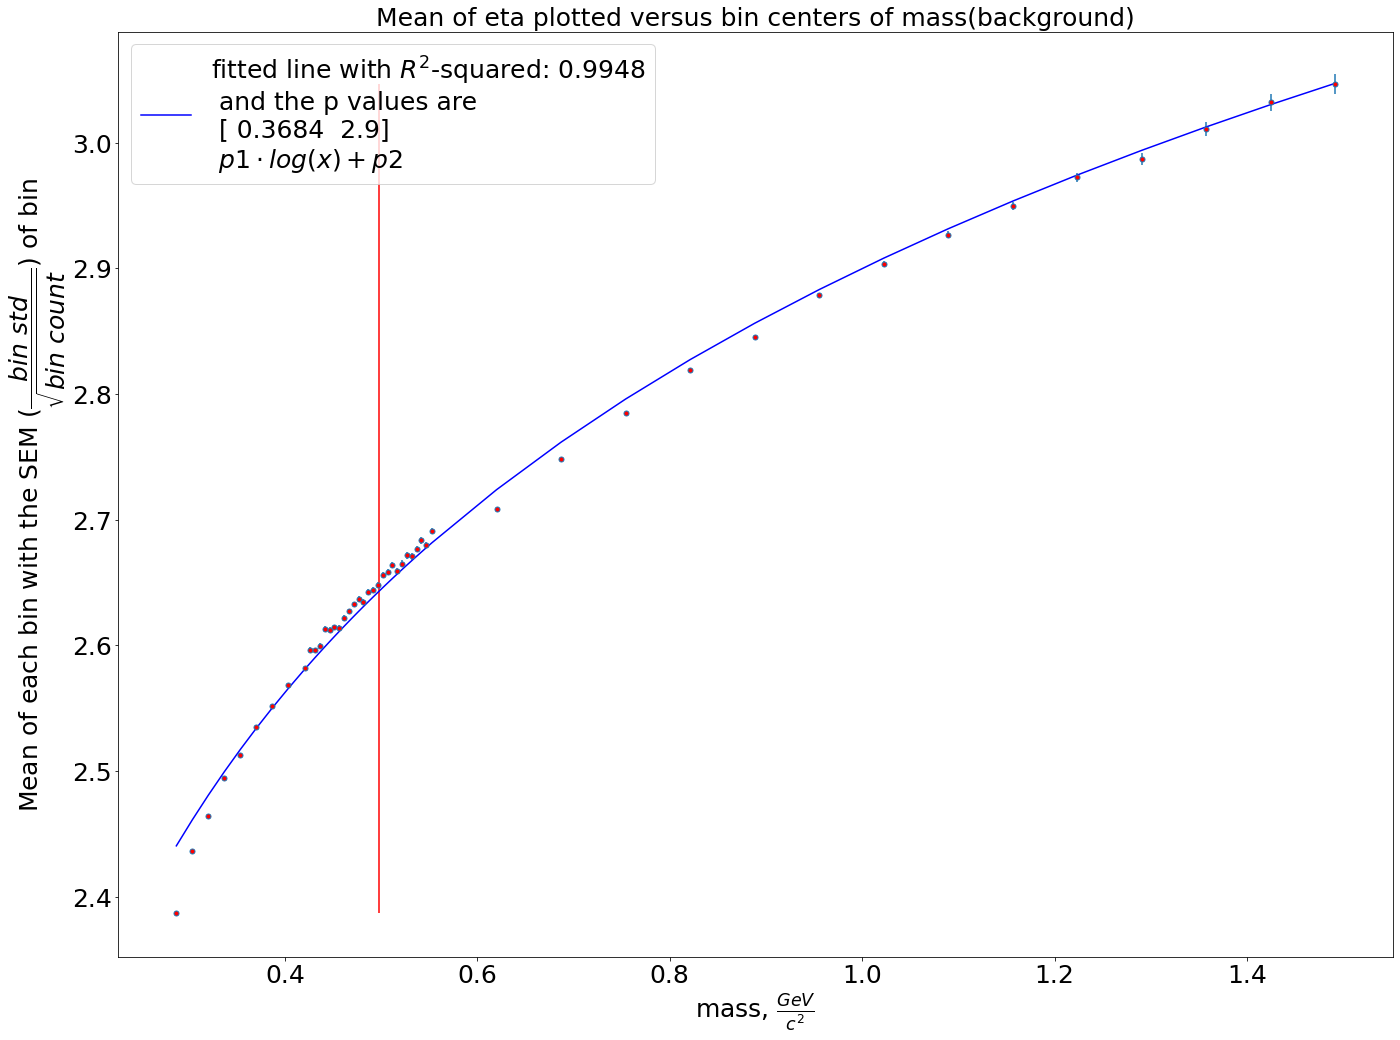

In [65]:
profile_plot_func(background,'mass','eta', 0, bckgr_mass_pdf, logar, non_uniform_binning)

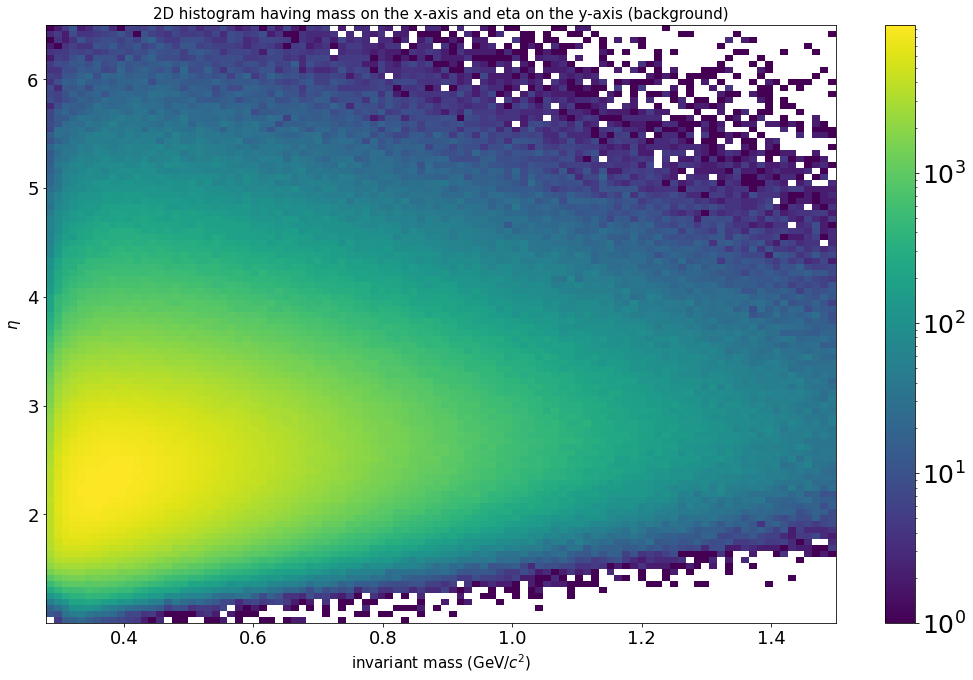

In [66]:
two_D_hist(background, 'mass', 'eta', bckgr_mass_pdf, 'background')

For $pT$

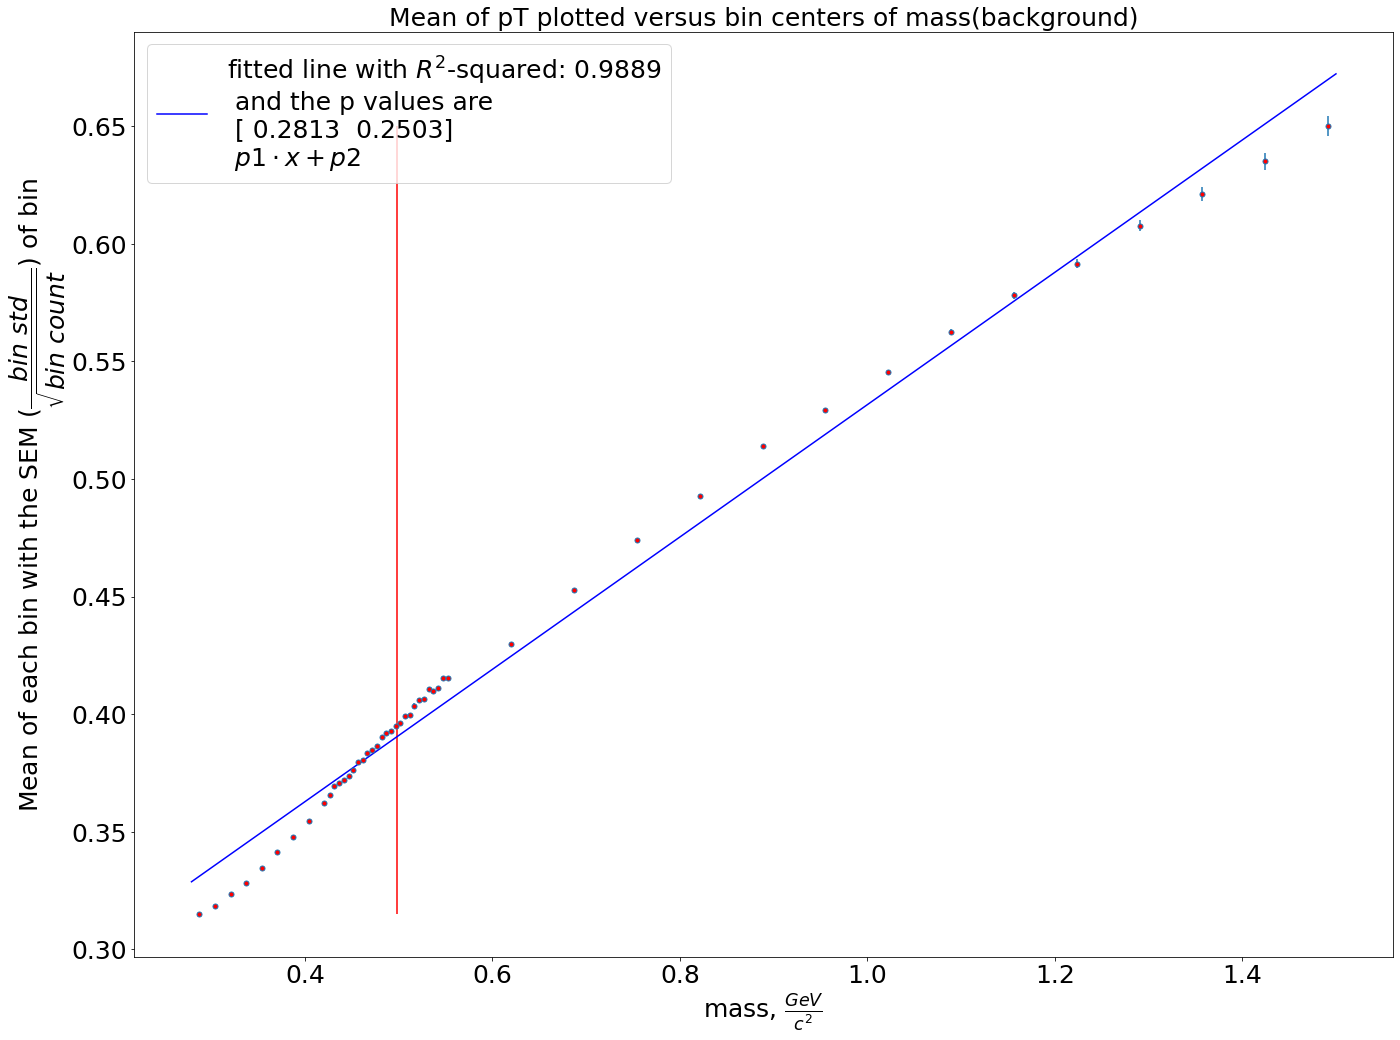

In [67]:
profile_plot_func(background,'mass','pT', 0, bckgr_mass_pdf, lin, non_uniform_binning)

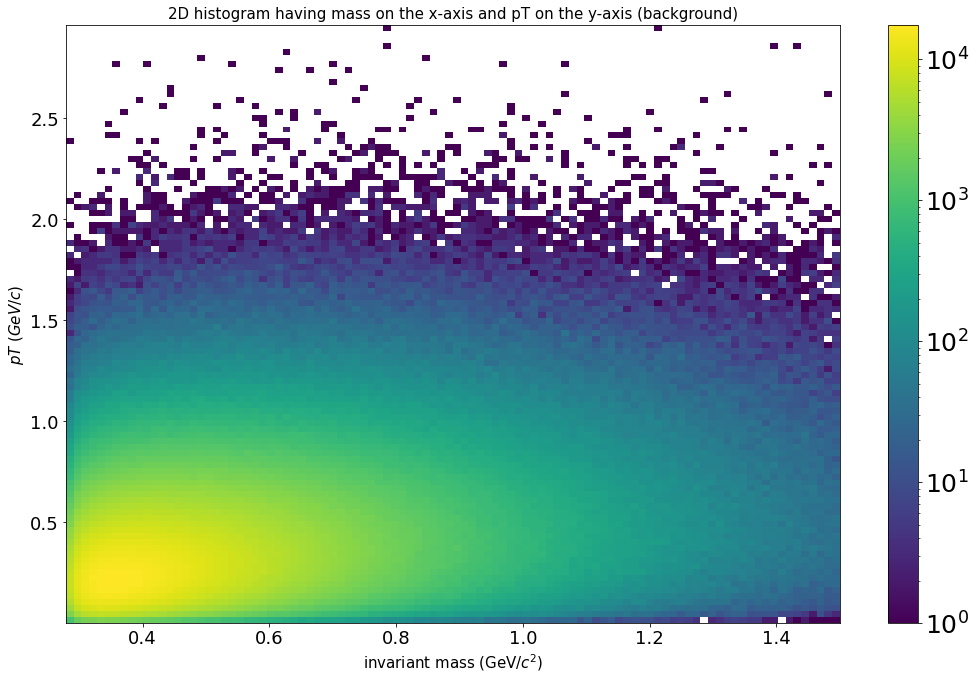

In [68]:
two_D_hist(background, 'mass', 'pT', bckgr_mass_pdf, 'background')

For $p_z$

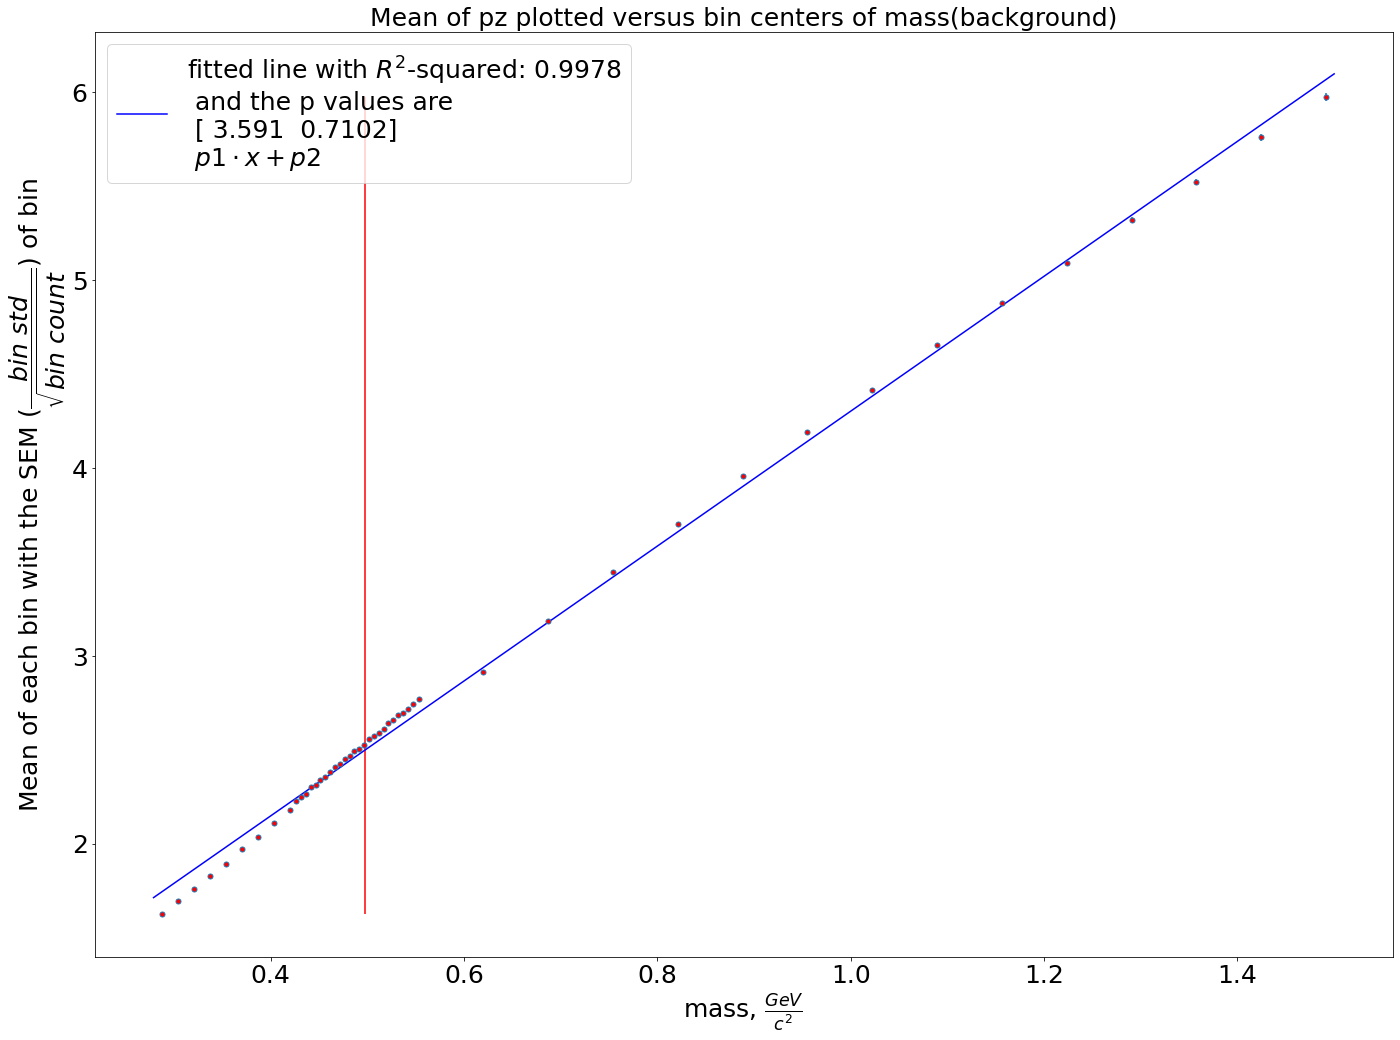

In [69]:
profile_plot_func(background,'mass','pz', 0, bckgr_mass_pdf, lin, non_uniform_binning)

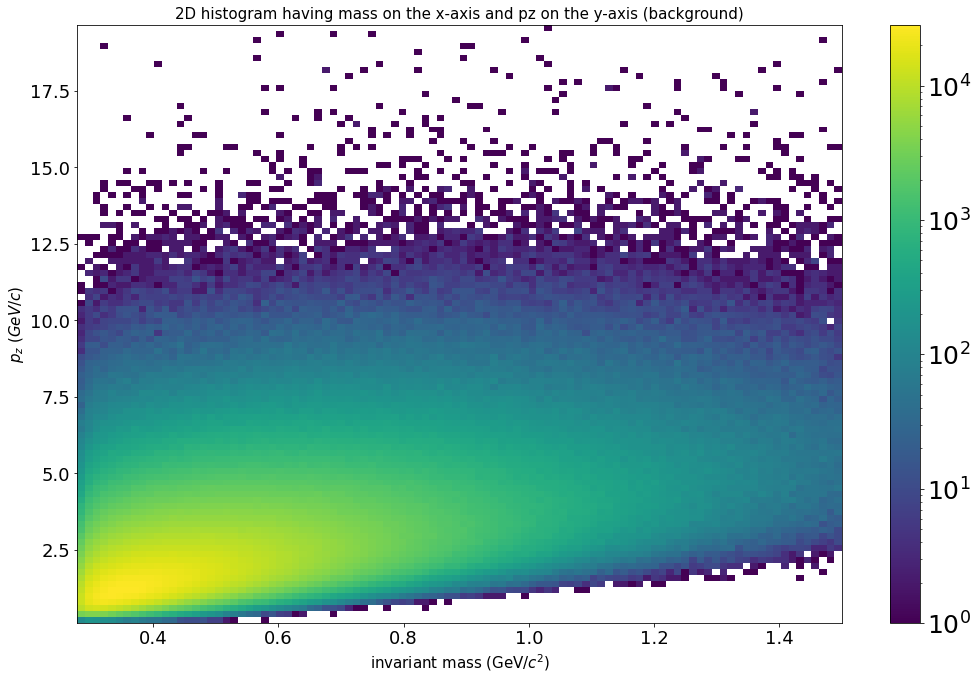

In [70]:
two_D_hist(background, 'mass', 'pz', bckgr_mass_pdf, 'background')

For $p$

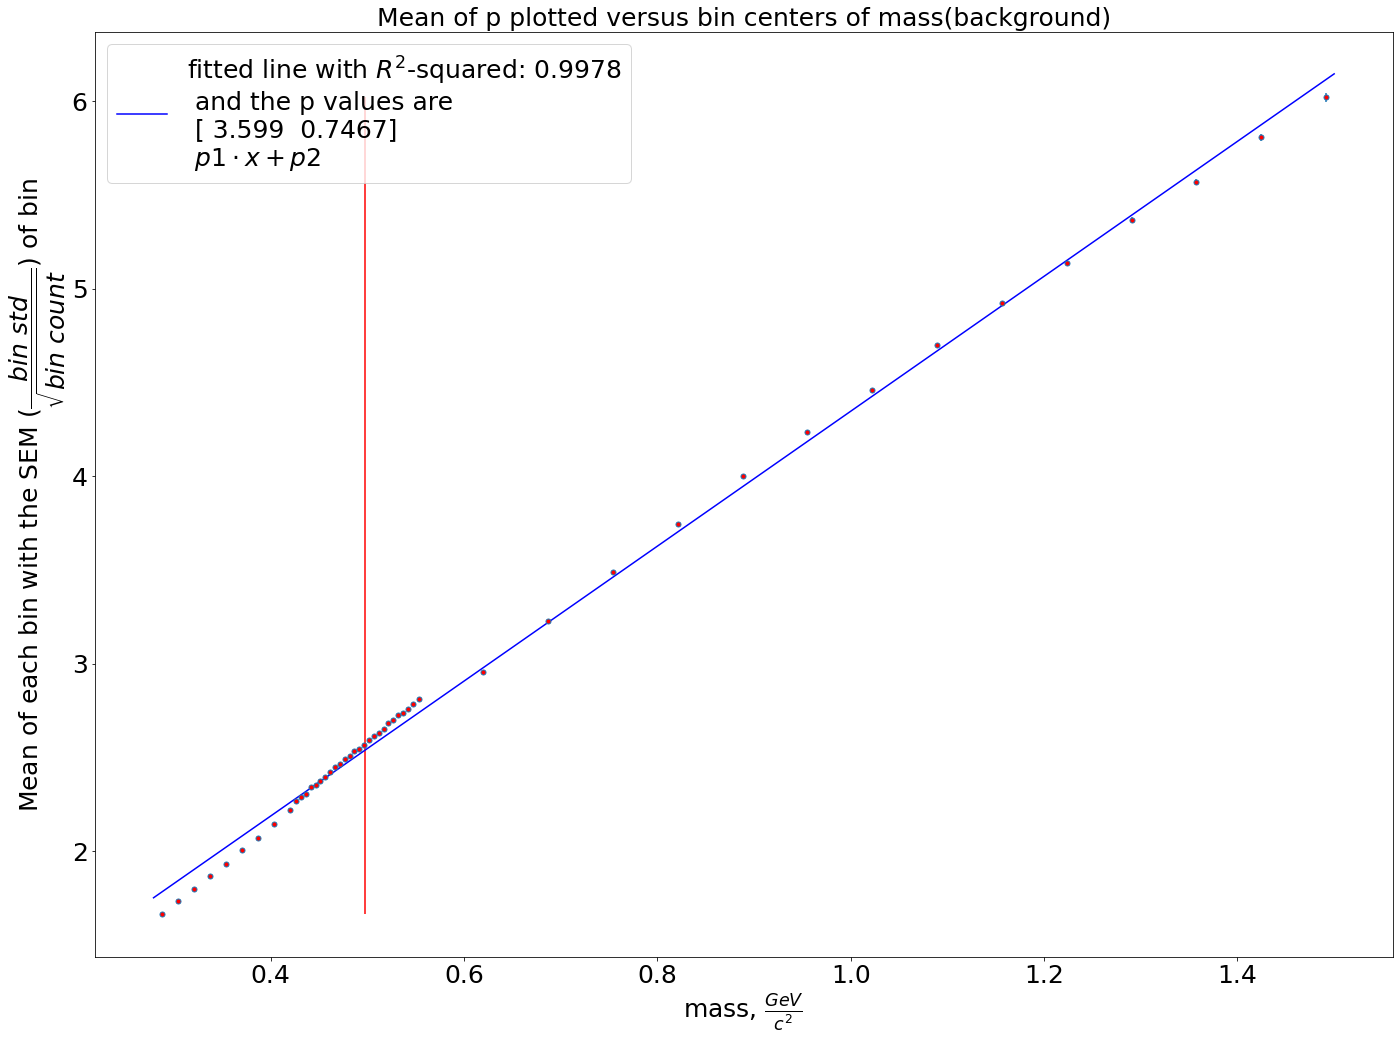

In [71]:
profile_plot_func(background,'mass','p', 0, bckgr_mass_pdf, lin, non_uniform_binning)

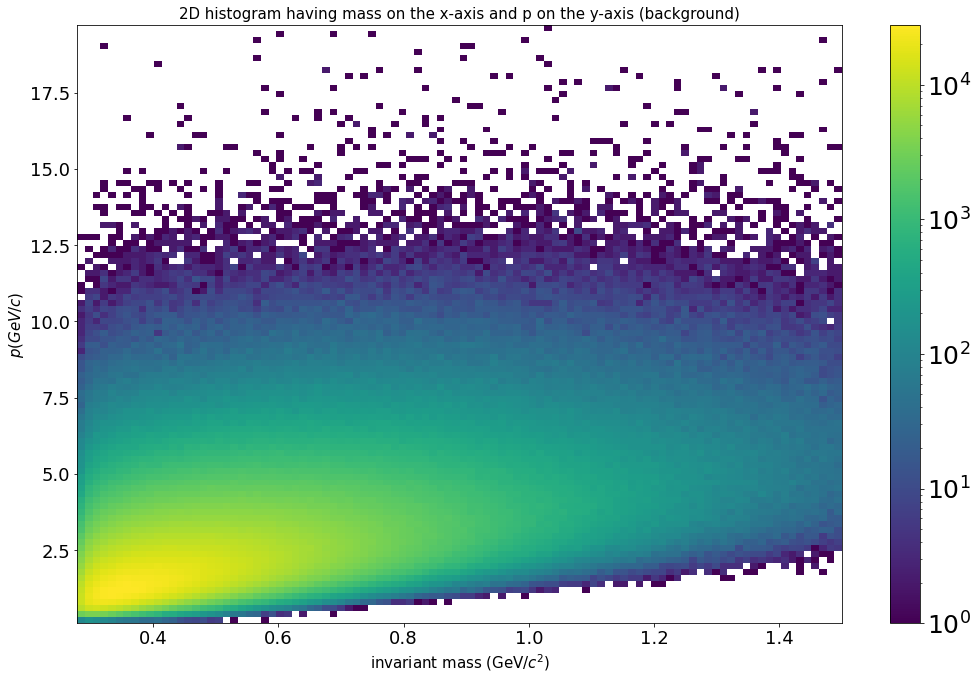

In [72]:
two_D_hist(background, 'mass', 'p', bckgr_mass_pdf, 'background')

For cosinefirst (the same will be for cosinesecond)

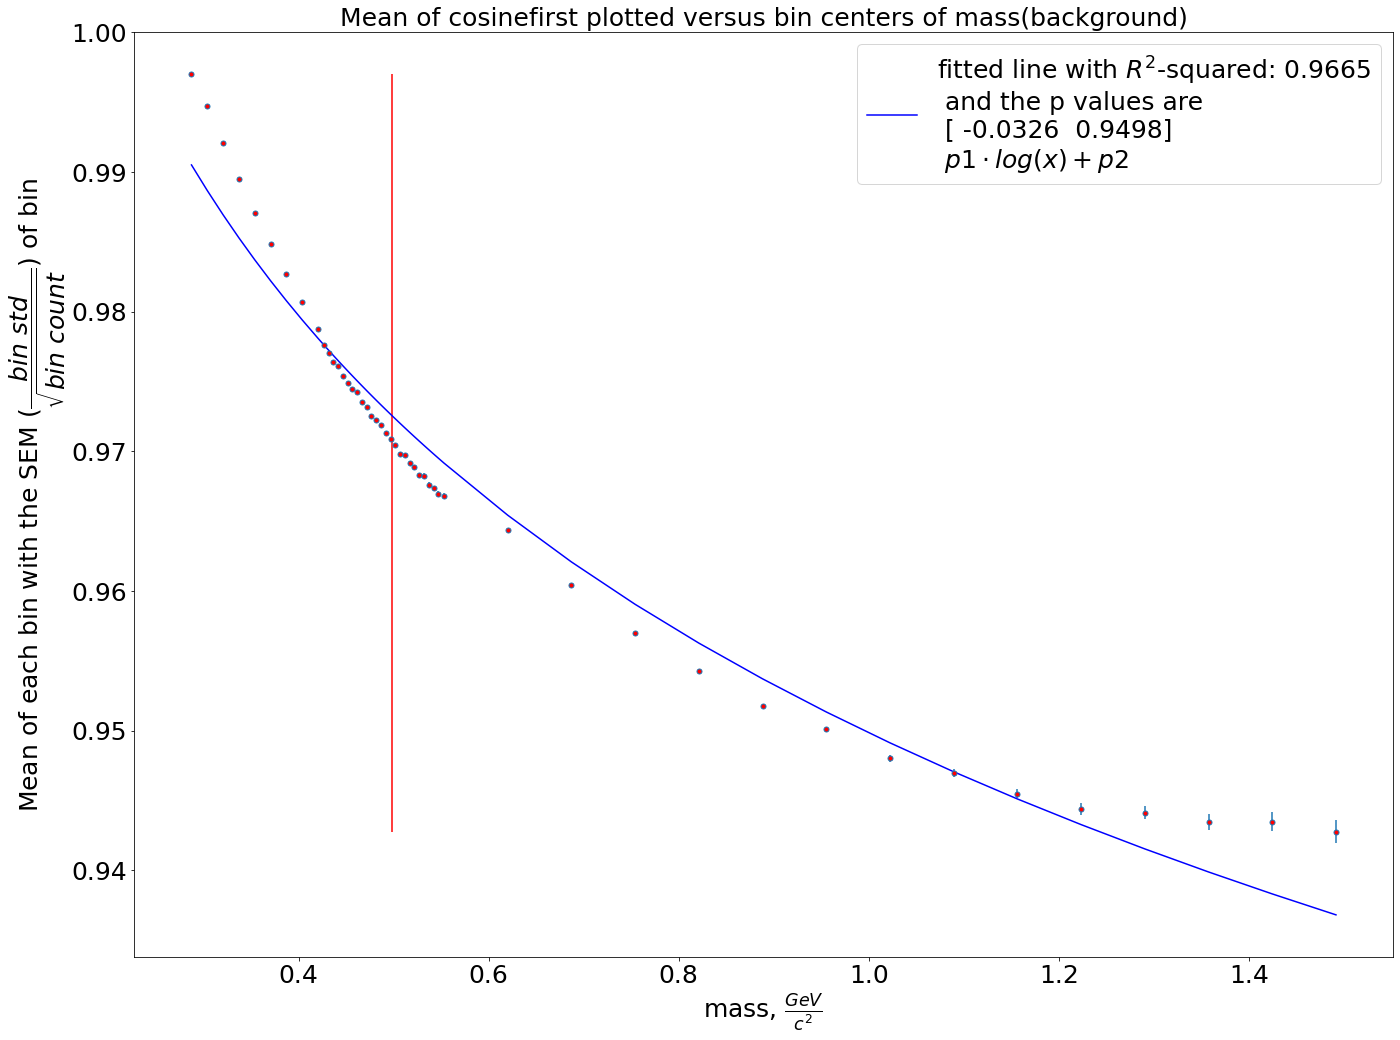

In [73]:
profile_plot_func(background,'mass','cosinefirst', 0, bckgr_mass_pdf, logar, non_uniform_binning)

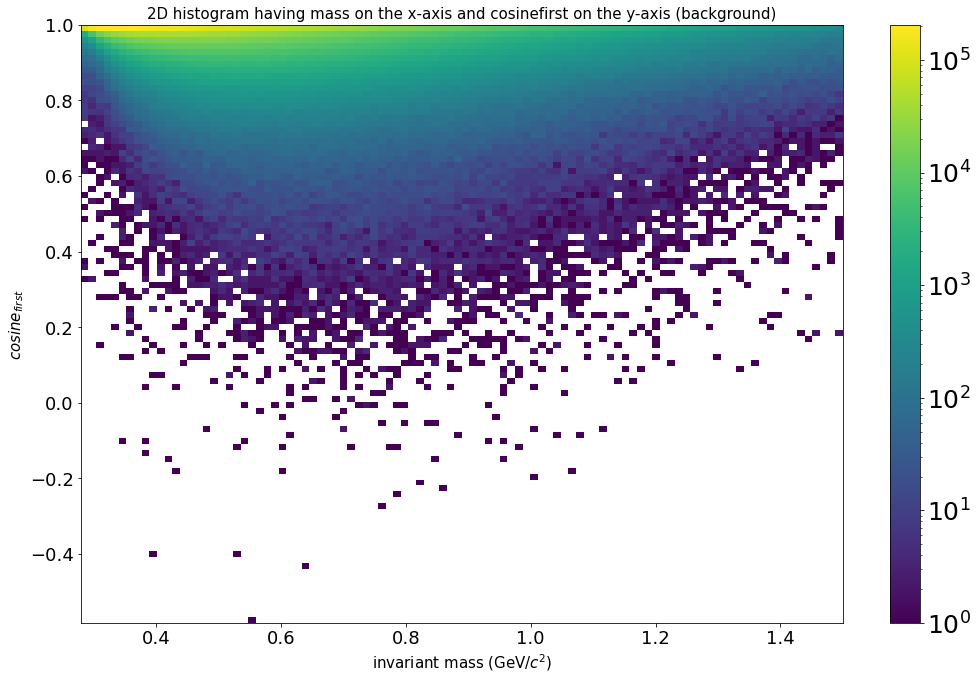

In [74]:
two_D_hist(background, 'mass', 'cosinefirst', bckgr_mass_pdf, 'background')

For cosinetopo

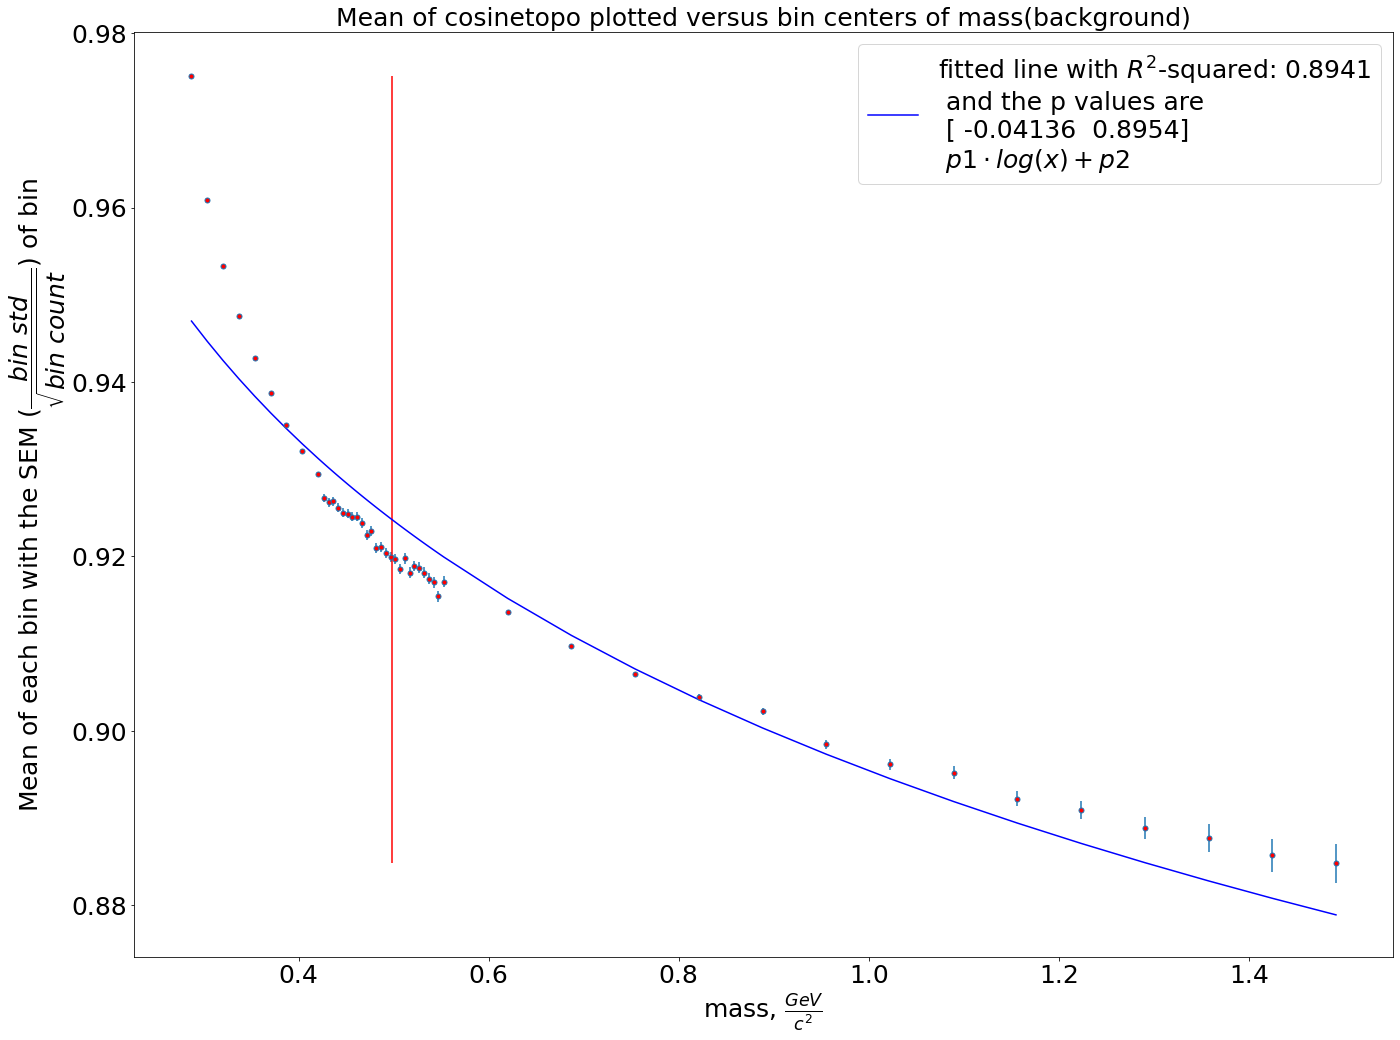

In [75]:
profile_plot_func(background,'mass','cosinetopo', 0, bckgr_mass_pdf, logar, non_uniform_binning)

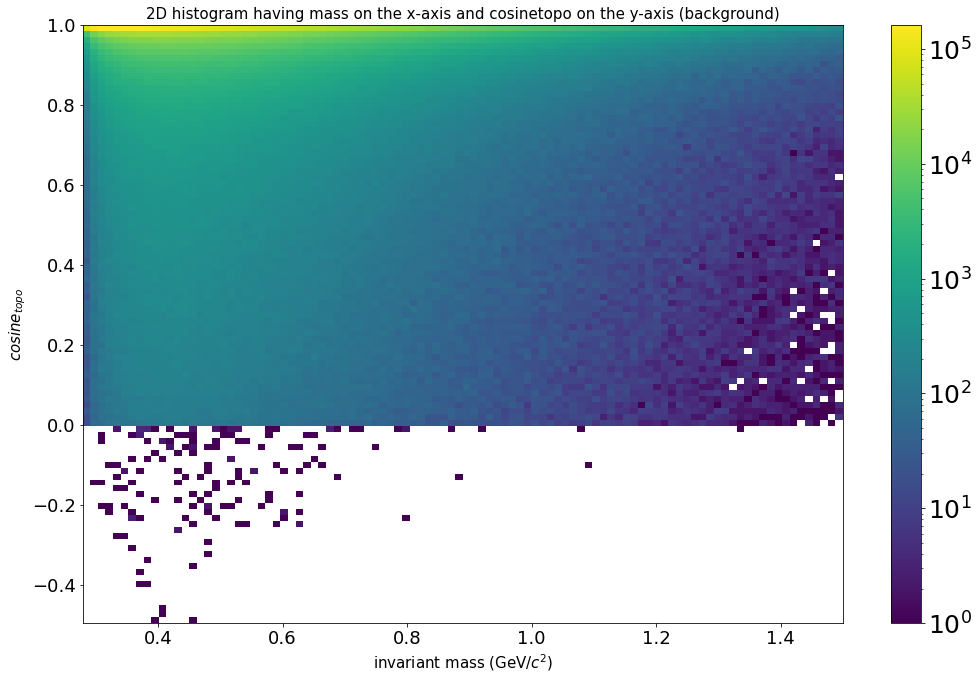

In [76]:
two_D_hist(background, 'mass', 'cosinetopo', bckgr_mass_pdf, 'background')

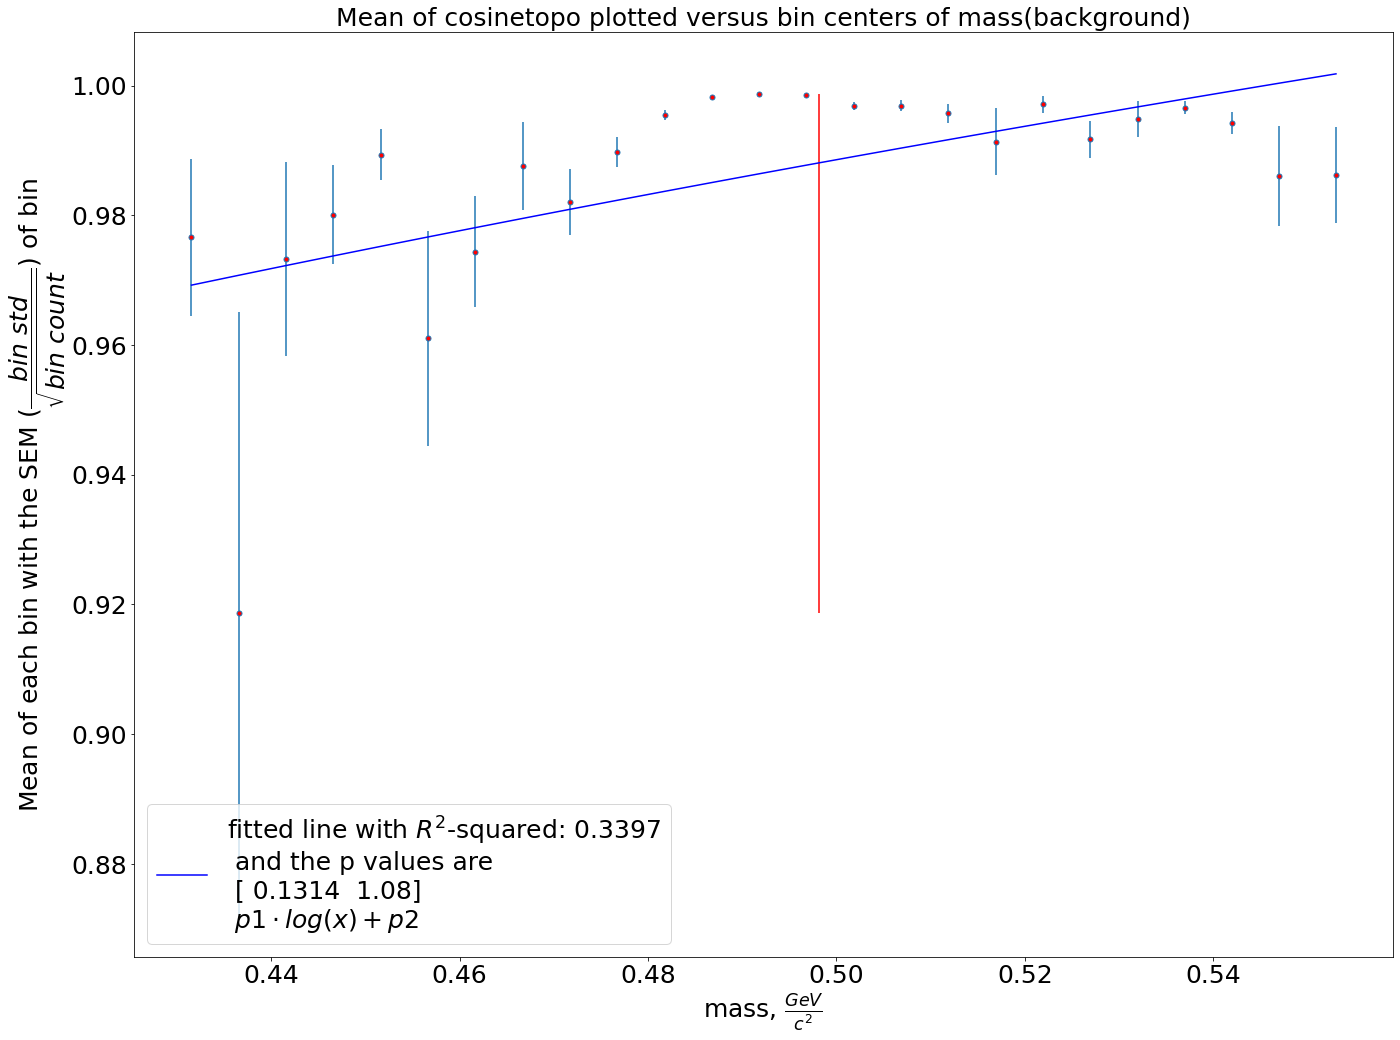

In [77]:
profile_plot_func(signal,'mass','cosinetopo', 0, bckgr_mass_pdf, logar, non_uniform_binning)

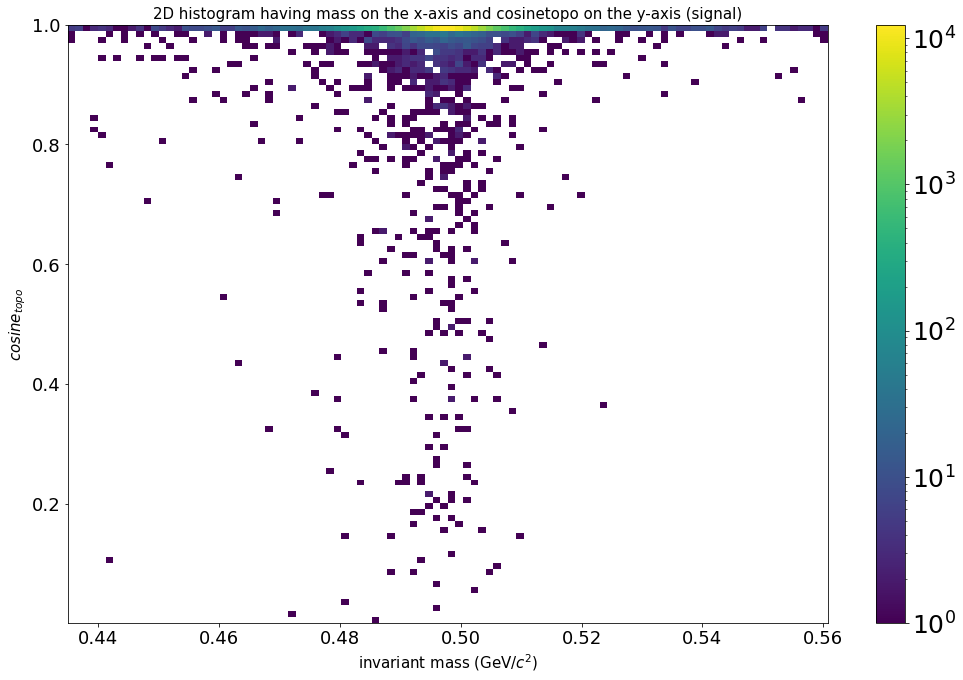

In [78]:
two_D_hist(signal, 'mass', 'cosinetopo', bckgr_mass_pdf, 'signal')

In [79]:
#let's close the pdf file
bckgr_mass_pdf.close()
gc.collect()

11359